In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# 1. Cargar los datasets y construir un único tablón analítico con todas las variables que consideremos necesarias para cada una de las cosechas que queremos analizar. (20%)

In [2]:
# Carga de fichero csv
clts_dic = pd.read_csv('../Tarea machine learning con python - REAL/diciembre/clientes_diciembre.csv', sep = '|')
prod_dic = pd.read_csv('../Tarea machine learning con python - REAL/diciembre/productos_diciembre.csv', sep = '|')
cons_dic = pd.read_csv('../Tarea machine learning con python - REAL/diciembre/consumos_diciembre.csv', sep = '|')
fina_dic = pd.read_csv('../Tarea machine learning con python - REAL/diciembre/financiacion_diciembre.csv', sep = '|')

clts_ene = pd.read_csv('../Tarea machine learning con python - REAL/enero/clientes_enero.csv', sep = '|')
prod_ene = pd.read_csv('../Tarea machine learning con python - REAL/enero/productos_enero.csv', sep = '|')
cons_ene = pd.read_csv('../Tarea machine learning con python - REAL/enero/consumos_enero.csv', sep = '|')
fina_ene = pd.read_csv('../Tarea machine learning con python - REAL/enero/financiacion_enero.csv', sep = '|')

In [3]:
# Impresión de dimensiones de los ficheros. 
# ¡OJO!Los datos de df_financiación tienen menos registros que el resto en los dos meses
# ¡OJO! Diciembre tiene casi 1.000 registros más en clientes, productos y consumos; y 1.000 registros menos en financiación
print("DATOS DICIEMBRE -> (Filas, Columnas)")
print("df_clientes ->",clts_dic.shape)
print("df_productos ->",prod_dic.shape)
print("df_consumos ->",cons_dic.shape)
print("df_financiación ->",fina_dic.shape) 

print("\nDATOS ENERO -> (Filas, Columnas)")
print("df_clientes ->", clts_ene.shape)
print("df_productos ->", prod_ene.shape)
print("df_consumos ->", cons_ene.shape)
print("df_finaciación ->",fina_ene.shape)


DATOS DICIEMBRE -> (Filas, Columnas)
df_clientes -> (95467, 8)
df_productos -> (95467, 4)
df_consumos -> (95467, 6)
df_financiación -> (24198, 4)

DATOS ENERO -> (Filas, Columnas)
df_clientes -> (92711, 8)
df_productos -> (92711, 4)
df_consumos -> (92711, 6)
df_finaciación -> (25332, 4)


In [4]:
#Unión de los conjuntos de datos de cada mes en una única tabla
df_diciembre = pd.merge(pd.merge(pd.merge(clts_dic, prod_dic, on = 'id', how = 'left'), cons_dic, on = 'id', how = 'left'),
                                  fina_dic, on = 'id', how = 'left')

df_enero = pd.merge(pd.merge(pd.merge(clts_ene, prod_ene, on = 'id', how = 'left'), cons_ene, on = 'id', how = 'left'),
                                  fina_ene, on = 'id', how = 'left')


# 2. Pre procesado y limpieza de datos (20%)

## 2.1 Inspección inicial y creación de variable objetivo

In [5]:
# Visualizamos las variables del conjunto de datos
df_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,FIBRA,50MB,tv-futbol,110,79,10897,12806,13751,NaN,NaN,NaN
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,FIBRA,600MB,tv-futbol,189,89,18657,6499,10862,NaN,NaN,SI
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,ADSL,35MB,tv-futbol,129,30,15511,17013,16743,NaN,NaN,SI
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,FIBRA,200MB,tv-familiar,51,52,12670,3393,6771,NaN,NaN,NaN
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,ADSL,10MB,tv-futbol,183,3,23756,18436,4485,NaN,NaN,NaN


In [6]:
df_diciembre.describe()

,id,edad,facturacion,num_lineas,num_dt,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,imp_financ
count,95467.000000,95467.000000,95467.000000,95467.000000,4729.000000,95467.000000,95467.000000,95467.000000,95467.000000,95467.000000,6372.000000
mean,49994.256832,49.779379,207.392912,3.559261,2.508141,124.815633,50.022762,12489.795898,9945.152849,9929.715221,22.268613
std,28873.008865,19.832963,111.343491,1.095542,1.121994,72.492338,29.119904,7239.421267,5784.158514,5819.207033,10.177659
min,1.000000,18.000000,15.000439,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.009999
25%,24997.500000,32.000000,111.383822,3.000000,2.000000,62.000000,25.000000,6177.500000,4951.000000,4910.000000,13.432253
50%,49970.000000,49.000000,206.808431,4.000000,3.000000,124.000000,50.000000,12466.000000,9923.000000,9922.000000,21.885534
75%,75021.500000,67.000000,304.436599,4.000000,4.000000,188.000000,75.000000,18785.500000,14948.500000,14961.000000,31.155292
max,100000.000000,85.000000,399.998433,39.000000,4.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,39.990128


In [7]:
# Lista de variables numéricas para detectar outliers
lista_numericas = ['edad', 'facturacion', 'num_lineas', 'num_dt', 'num_llamad_ent', 'num_llamad_sal', 'mb_datos',
                   'seg_llamad_ent', 'seg_llamad_sal', 'imp_financ']

In [8]:
# Crear una variable dicotómica 'Churn' que clasifique a clientes que siguen (0) y los que se han marchado (1).
# La variable Churn será la variable objetivo del modelo

no_enero = []
lista_ids = list(df_enero['id'])

for i in df_diciembre['id']:
    if i not in lista_ids:
        no_enero.append(1)
    else:
        no_enero.append(0)

df_diciembre.insert(0, 'churn', no_enero)

In [9]:
df_diciembre.columns

Index(['churn', 'id', 'edad', 'facturacion', 'antiguedad', 'provincia',
       'num_lineas', 'num_dt', 'incidencia', 'conexion', 'vel_conexion', 'TV',
       'num_llamad_ent', 'num_llamad_sal', 'mb_datos', 'seg_llamad_ent',
       'seg_llamad_sal', 'financiacion', 'imp_financ', 'descuentos'],
      dtype='object')

In [10]:
# ¡OJO! Se puede apreciar una variable objetivo desbalanceada. Tenerlo en cuenta para clasificación
df_diciembre['churn'].value_counts()

0    88382
1     7085
Name: churn, dtype: int64

In [11]:
# Fijamos ID como indice
df_diciembre.set_index('id', inplace = True)
df_enero.set_index('id', inplace = True)

## Tratamos antigüedad. La convertimos a meses de antigüedad 

In [12]:
# Convertir la antiguedad de df_diciembre a meses
fecha = df_diciembre['antiguedad']
fecha = fecha.str.split(expand = True)
fecha = pd.to_datetime(fecha.iloc[:,0])

ultimo_dia_diciembre = pd.to_datetime('2019-12-31')
a = ultimo_dia_diciembre - fecha

meses = a.astype('timedelta64[M]')
meses = meses.astype('int')

In [13]:
#convertimos la antiguedad de df_enero a meses
fecha_enero = df_enero['antiguedad']
fecha_enero = fecha_enero.str.split(expand = True)
fecha_enero = pd.to_datetime(fecha_enero.iloc[:,0])

ultimo_dia_enero = pd.to_datetime('2020-01-31')
a = ultimo_dia_enero - fecha_enero

meses_enero = a.astype('timedelta64[M]')
meses_enero = meses_enero.astype('int')

In [14]:
# Incluimos la variable antigüedad en meses en diciembre
df_diciembre.insert(5, 'meses_antig', meses)

# Incluimos la variable antigüedad en meses en enero
df_enero.insert(5, 'meses_antig', meses_enero)

In [15]:
# Los nuevos clientes de enero no tienen antigüedad por lo que los igualaremos a cero
df_enero[df_enero['meses_antig'].isnull()] = 0

In [16]:
# Eliminamos la variable antiguedad en formato fecha de diciembre
df_diciembre.head()
df_diciembre.drop('antiguedad', axis=1, inplace=True)

# Eliminamos la variable antiguedad en formato fecha de enero
df_enero.head()
df_enero.drop('antiguedad', axis=1, inplace=True)

In [17]:
#incluimos meses_antig en la lista de variables numéricas
lista_numericas.append('meses_antig')

## Tratamos provincia. La convertimos a numérica con su código de provincia

Obtenemos código de provincia con scraping del siguiente enlace https://es.wikipedia.org/wiki/Anexo:Provincias_de_Espa%C3%B1a_por_c%C3%B3digo_postal

In [18]:
url = "https://es.wikipedia.org/wiki/Anexo:Provincias_de_Espa%C3%B1a_por_c%C3%B3digo_postal"
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html')

In [19]:
table_cp_prov = soup.find('table', attrs={'class':'sortablputas ricolinas010hzjswikitable'})

In [20]:
df = pd.read_html(str(table_cp_prov))
df = df[0]
df['Provincia'].replace({'A Coruña':'La Coruña', 'Baleares':'Islas Baleares', 'Ourense':'Orense', 'Gerona/Girona': 'Gerona', 'Lérida/Lleida':'Lérida' }, inplace = True)

In [21]:
# Creamos diccionario para reemplazar valores en df_diciembre['provincia']
dict_cp_prov = dict(zip(df['Provincia'], df['Código postal']))
df_diciembre['provincia'].replace(dict_cp_prov, inplace = True)

#Aplicamos los cambios en df_enero
df_enero['provincia'].replace(dict_cp_prov, inplace = True)

In [22]:
#incluimos provincia en la lista de variables numéricas
lista_numericas.append('provincia')

## Detección de outliers

In [23]:
df_diciembre[lista_numericas].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95467 entries, 1 to 100000
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   edad            95467 non-null  int64  
 1   facturacion     95467 non-null  float64
 2   num_lineas      95467 non-null  int64  
 3   num_dt          4729 non-null   float64
 4   num_llamad_ent  95467 non-null  int64  
 5   num_llamad_sal  95467 non-null  int64  
 6   mb_datos        95467 non-null  int64  
 7   seg_llamad_ent  95467 non-null  int64  
 8   seg_llamad_sal  95467 non-null  int64  
 9   imp_financ      6372 non-null   float64
 10  meses_antig     95467 non-null  int32  
 11  provincia       95467 non-null  int64  
dtypes: float64(3), int32(1), int64(8)
memory usage: 9.1 MB


In [24]:
# Detectamos outliers
for n in lista_numericas:
    z = np.abs(stats.zscore(df_diciembre[n]))
    threshold = 3
    print(f'{n:15} --> {np.where(z>3)}')      

edad            --> (array([], dtype=int64),)
facturacion     --> (array([], dtype=int64),)
num_lineas      --> (array([ 2580,  8657, 36987], dtype=int64),)
num_dt          --> (array([], dtype=int64),)
num_llamad_ent  --> (array([], dtype=int64),)
num_llamad_sal  --> (array([], dtype=int64),)
mb_datos        --> (array([], dtype=int64),)
seg_llamad_ent  --> (array([], dtype=int64),)
seg_llamad_sal  --> (array([], dtype=int64),)
imp_financ      --> (array([], dtype=int64),)
meses_antig     --> (array([], dtype=int64),)
provincia       --> (array([], dtype=int64),)


{'whiskers': [<matplotlib.lines.Line2D at 0x2106e7aaac0>,
 'caps': [<matplotlib.lines.Line2D at 0x2106e7c01c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2106e7aa760>],
 'medians': [<matplotlib.lines.Line2D at 0x2106e7c0880>],
 'fliers': [<matplotlib.lines.Line2D at 0x2106e7c0be0>],
 'means': []}

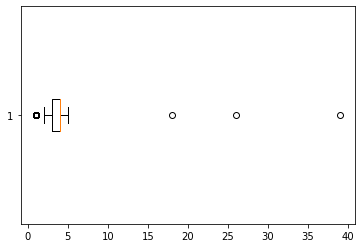

In [25]:
# Hacemos un boxplot para representar graficamente la distribución de num_lineas
plt.boxplot(df_diciembre['num_lineas'], vert = False)

In [26]:
# Los outliers se detectan por encima de 10 lineas. Eliminamos estos valores
df_diciembre.drop(df_diciembre[df_diciembre.num_lineas>10].index, inplace=True)

## Tratamiento de nulos

In [27]:
# Variables con nulos: num_dt, incidencia, vel_conexion, finaciacion, imp_financ, descuento
# Todas las variables con valores nulos salvo vel_conexion tienen un alto % de valores perdidos
df_diciembre.isnull().mean()

churn             0.000000
edad              0.000000
facturacion       0.000000
provincia         0.000000
meses_antig       0.000000
num_lineas        0.000000
num_dt            0.950463
incidencia        0.962562
conexion          0.000000
vel_conexion      0.000031
TV                0.000000
num_llamad_ent    0.000000
num_llamad_sal    0.000000
mb_datos          0.000000
seg_llamad_ent    0.000000
seg_llamad_sal    0.000000
financiacion      0.933252
imp_financ        0.933252
descuentos        0.799380
dtype: float64

In [28]:
# Inspeccionar valores únicos de variables con nulos
print(df_diciembre.num_dt.unique(), df_diciembre.incidencia.unique(), 
      df_diciembre.financiacion.unique(), df_diciembre.imp_financ.unique(), df_diciembre.descuentos.unique())

[nan  2.  1.  4.  3.] [nan 'SI'] [nan 'SI'] [        nan 31.55326856 28.51874706 ... 28.35559612 23.13877851
 14.61642214] [nan 'SI']


In [29]:
# Las variables con valores dicotómicos las convertiremos en binarias: nan = 0, SI = 1
dicotomicas = ['incidencia', 'financiacion', 'descuentos']

for i in dicotomicas:
    df_diciembre[i] = df_diciembre[i].fillna(0)
    df_diciembre[i].replace('SI', 1, inplace=True)
    df_enero[i] = df_enero[i].fillna(0)
    df_enero[i].replace('SI', 1, inplace=True)
                        

In [30]:
# Los nulos en financiación y en imp_financ coincide. Podemos concluir que los clientes que no están financiados tienen 0€ de
# importe financiado
print(df_diciembre['financiacion'].value_counts())
print(df_diciembre['imp_financ'].isnull().sum())

0    89092
1     6372
Name: financiacion, dtype: int64
89092


In [31]:
# En las varibales con multiples valores y nan reemplazamos el nan por cero. 
# Entendemos que en num_dt los nulos son clientes sin lineas en impago y los nulos en imp_financ no tienen finaciación
df_diciembre['num_dt'] = df_diciembre['num_dt'].fillna(0)
df_diciembre['imp_financ'] = df_diciembre['imp_financ'].fillna(0)

#Aplicamos los cambios a df_enero
df_enero['num_dt'] = df_enero['num_dt'].fillna(0)
df_enero['imp_financ'] = df_enero['imp_financ'].fillna(0)


In [32]:
df_diciembre.isna().mean()

churn             0.000000
edad              0.000000
facturacion       0.000000
provincia         0.000000
meses_antig       0.000000
num_lineas        0.000000
num_dt            0.000000
incidencia        0.000000
conexion          0.000000
vel_conexion      0.000031
TV                0.000000
num_llamad_ent    0.000000
num_llamad_sal    0.000000
mb_datos          0.000000
seg_llamad_ent    0.000000
seg_llamad_sal    0.000000
financiacion      0.000000
imp_financ        0.000000
descuentos        0.000000
dtype: float64

In [33]:
df_enero.isna().mean()

edad              0.000000
facturacion       0.000000
provincia         0.000000
num_lineas        0.000000
meses_antig       0.000000
num_dt            0.000000
incidencia        0.000000
conexion          0.000022
vel_conexion      0.000032
TV                0.000000
num_llamad_ent    0.000000
num_llamad_sal    0.000000
mb_datos          0.000000
seg_llamad_ent    0.000000
seg_llamad_sal    0.000000
financiacion      0.000000
imp_financ        0.000000
descuentos        0.000000
dtype: float64

In [34]:
# Los valores nulos en conexión en enero los igualaremos a la moda
df_enero['conexion'].fillna(df_enero['conexion'].mode()[0], inplace=True)

In [35]:
# Los valores nulos en vel_conexion son despreciables. Igualaremos los registros a la moda
df_diciembre['vel_conexion'].fillna(df_diciembre['vel_conexion'].mode()[0], inplace=True)
df_enero['vel_conexion'].fillna(df_enero['vel_conexion'].mode()[0], inplace=True)

In [36]:
# Parece que hay tres valores mal codificados.
df_diciembre['vel_conexion'].value_counts()

200MB    9678
600MB    9622
50MB     9474
300MB    9458
100MB    9331
20MB     8113
25MB     8112
10MB     7969
30MB     7948
35MB     7947
15MB     7809
?           1
16598       1
1           1
Name: vel_conexion, dtype: int64

In [37]:
# Eliminamos 3 valores extraños de velocidad de conexión en diciembre
df_diciembre.drop(df_diciembre[df_diciembre['vel_conexion']== '16598'].index, inplace = True)
df_diciembre.drop(df_diciembre[df_diciembre['vel_conexion']== '1'].index, inplace = True)
df_diciembre.drop(df_diciembre[df_diciembre['vel_conexion']== '?'].index, inplace = True)

In [38]:
df_enero['vel_conexion'].value_counts()

200MB    9345
600MB    9299
300MB    9212
50MB     9167
100MB    9099
20MB     7882
25MB     7840
10MB     7807
30MB     7761
35MB     7672
15MB     7627
Name: vel_conexion, dtype: int64

In [39]:
# La variable está como objeto y podemos convertirla a numérica eliminando el MB
df_diciembre['vel_conexion'].unique()

array(['50MB', '600MB', '35MB', '200MB', '10MB', '25MB', '30MB', '100MB',
       '20MB', '300MB', '15MB'], dtype=object)

In [40]:
df_diciembre.head()

,churn,edad,facturacion,provincia,meses_antig,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,financiacion,imp_financ,descuentos
id,,,,,,,,,,,,,,,,,,,
1,0,63,216.028109,26,13,5,0.0,0,FIBRA,50MB,tv-futbol,110,79,10897,12806,13751,0,0.0,0
2,0,84,255.830842,48,28,3,0.0,0,FIBRA,600MB,tv-futbol,189,89,18657,6499,10862,0,0.0,1
3,0,66,135.768153,2,216,4,0.0,0,ADSL,35MB,tv-futbol,129,30,15511,17013,16743,0,0.0,1
4,0,69,255.658527,27,52,4,0.0,0,FIBRA,200MB,tv-familiar,51,52,12670,3393,6771,0,0.0,0
5,1,30,22.302845,43,268,2,2.0,0,ADSL,10MB,tv-futbol,183,3,23756,18436,4485,0,0.0,0


In [41]:
numeric_vel_conexion = df_diciembre.vel_conexion.str.split('MB', expand = True)
numeric_vel_conexion = numeric_vel_conexion.iloc [:,0]
numeric_vel_conexion = numeric_vel_conexion.astype(int)
df_diciembre['vel_conexion'] = numeric_vel_conexion 
df_diciembre['vel_conexion'].unique()

#Aplicamos cambios en enero
numeric_vel_conexion = df_enero.vel_conexion.str.split('MB', expand = True)
df_enero['vel_conexion'] = numeric_vel_conexion
df_enero['vel_conexion'].unique()

array(['50', '600', '35', '200', '25', '30', '10', '100', '20', '300',
       '15'], dtype=object)

In [42]:
df_enero['vel_conexion'].unique()

array(['50', '600', '35', '200', '25', '30', '10', '100', '20', '300',
       '15'], dtype=object)

## Tratamiento  variables categóricas

In [43]:
# En principio definimos como categoricas aquellas variables con menos de 10 valores diferentes.
# Más adelante miraremos si se pueden agrupar de variables numéricas con poca representación en categorías
for i in df_diciembre.columns:

    print(f'{i:15} ==>  {len(df_diciembre[i].unique())}')

churn           ==>  2
edad            ==>  68
facturacion     ==>  95461
provincia       ==>  50
meses_antig     ==>  300
num_lineas      ==>  5
num_dt          ==>  5
incidencia      ==>  2
conexion        ==>  2
vel_conexion    ==>  11
TV              ==>  3
num_llamad_ent  ==>  251
num_llamad_sal  ==>  101
mb_datos        ==>  24456
seg_llamad_ent  ==>  19829
seg_llamad_sal  ==>  19821
financiacion    ==>  2
imp_financ      ==>  6373
descuentos      ==>  2


In [44]:
# Por el número de valores únicos convertidos eliminamos dos variables de la lista de numericas para incluirlas en categóricas
lista_numericas.remove('num_dt')
lista_numericas.remove('num_lineas')

In [45]:
# Definimos las variables categoricas. No metemos churn ya que es la variable objetivo
lista_categoricas = ['num_lineas', 'num_dt', 'incidencia', 'conexion', 'vel_conexion', 'TV', 'financiacion', 'descuentos']

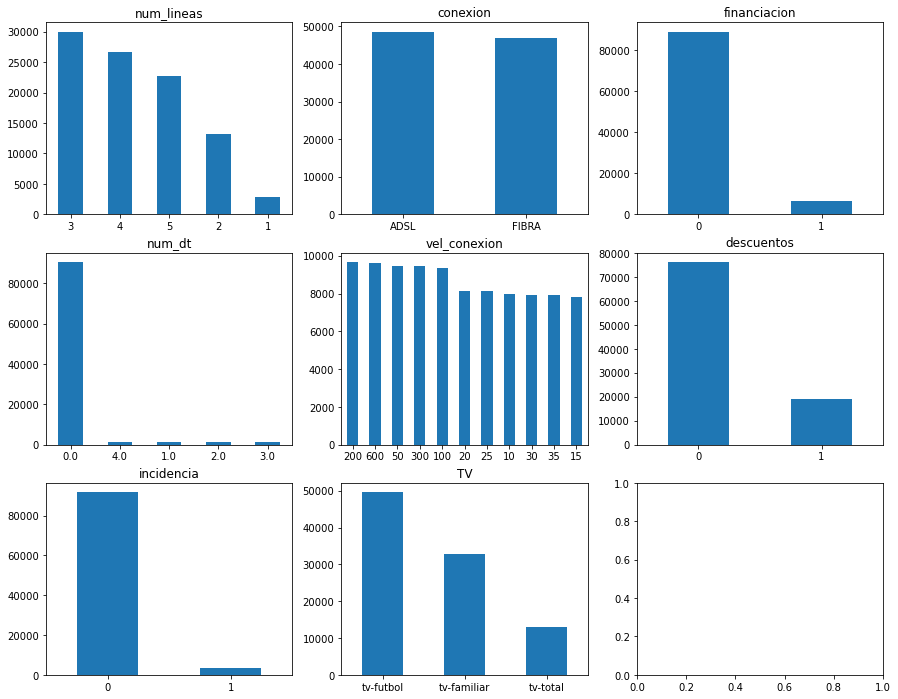

In [46]:
#Visualización distribución variables categoricas

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12))

for i, item in enumerate(lista_categoricas):
    if i < 3:
        ax = df_diciembre[item].value_counts().plot(kind = 'bar', ax = axes[i, 0], rot = 0)
    
    elif i >= 3 and i < 6:
        ax = df_diciembre[item].value_counts().plot(kind = 'bar', ax = axes[i-3, 1], rot = 0)
        
    else:
        ax = df_diciembre[item].value_counts().plot(kind = 'bar', ax = axes[i-6, 2], rot = 0)
        
    ax.set_title(item)

In [47]:
# num_dt concentra sus valores en 0. Para simplificarla la convertimos en dicotomica: 0 (no impago) y 1 (impago)
df_diciembre['num_dt'] = df_diciembre['num_dt'].apply(lambda x: 0 if x==0 else 1)

#Aplicamos cambios en enero
df_enero['num_dt'] = df_enero['num_dt'].apply(lambda x: 0 if x==0 else 1)


In [48]:
# Conexión solo tiene valores ADSL y FIBRA. Las renombramos ADSL(0) y FIBRA(1)
df_diciembre['conexion'].replace({'ADSL': 0, 'FIBRA': 1}, inplace = True)

# Aplicamos cambios en enero
df_enero['conexion'].replace({'ADSL': 0, 'FIBRA': 1}, inplace = True)


In [49]:
# Pasamos categóricas con más de 2 valores únicos a dummies
categoricas_dummies = ['num_lineas', 'vel_conexion', 'TV']
for k in categoricas_dummies:
    dummies = pd.get_dummies(df_diciembre[k],prefix=k)
    df_diciembre = pd.concat([df_diciembre, dummies], axis=1)
# Aplicamos cambios en enero
    dummies_ene = pd.get_dummies(df_enero[k],prefix=k)
    df_enero = pd.concat([df_enero, dummies_ene], axis=1)

In [50]:
#eliminamos variables originales
df_diciembre.drop(['num_lineas', 'vel_conexion', 'TV'], axis = 1, inplace = True)

# Aplicamos cambios en enero
df_enero.drop(['num_lineas', 'vel_conexion', 'TV'], axis = 1, inplace = True)

In [51]:
# Consideramos que Provincia será categoríca pero no la convertimos a dummies ya que tiene 50 valores únicos
lista_numericas.remove('provincia')
lista_categoricas.append('provincia')

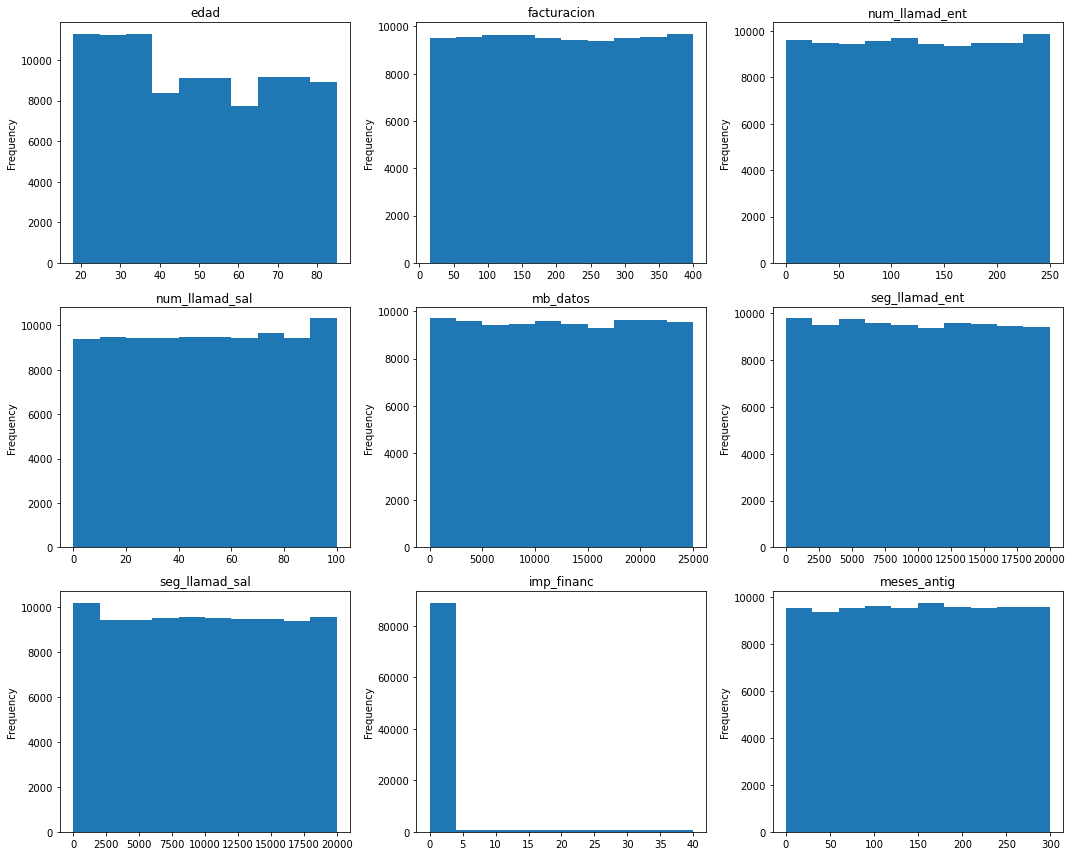

In [52]:
# Histograma de variables numéricas para ver si se pueden categorizar
fig, axes = fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 12))
   
    
for i, item in enumerate(lista_numericas):
    if i < 3:
        ax = df_diciembre[item].plot(kind = 'hist', ax = axes[0, i], rot = 0)
    
    elif i >= 3 and i < 6:
        ax = df_diciembre[item].plot(kind = 'hist', ax = axes[1, i-3], rot = 0)
        
    elif i >= 6 and i < 9:
        ax = df_diciembre[item].plot(kind = 'hist', ax = axes[2, i-6], rot = 0)
        
    else:
        ax = df_diciembre[item].plot(kind = 'hist', ax = axes[3, i-9], rot = 0)
        
    ax.set_title(item)
    fig.tight_layout()

In [53]:
#imp_financ puede categorizarse en ceros y unos. Al tener los mismo valores que financiación la borramos de df y lista_numericas
df_diciembre.drop('imp_financ', axis=1, inplace=True)
lista_numericas.remove('imp_financ')

#Aplicamos cambios en enero
df_enero.drop('imp_financ', axis=1, inplace=True)

In [54]:
# Observamos que las variables con mayor influencia sobre el churn son: num_dt_0.0, edad, incidencia, TV_tv_futbol y descuentos
corr = abs(df_diciembre.corr())
corr[['churn']].sort_values(by = 'churn',ascending = False).style.background_gradient()

,churn
churn,1.000000
num_dt,0.346511
edad,0.296818
incidencia,0.277431
TV_tv-futbol,0.152469
descuentos,0.141438
TV_tv-total,0.111100
TV_tv-familiar,0.079970
financiacion,0.074596
conexion,0.051431


<AxesSubplot:>

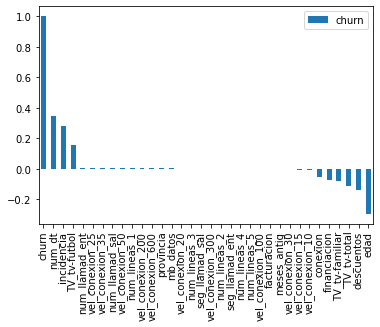

In [55]:
# Analizamos el tipo de correlación
corr = df_diciembre.corr()
corr[['churn']].sort_values(by='churn',ascending = False).plot(kind='bar')

## Escalamos variables continuas al estar en diferentes unidades

In [56]:
# Al ser valores medidos en distintas unidades normalizamos las variables continuas
estandarizar = StandardScaler()
df_diciembre[lista_numericas] = estandarizar.fit_transform(df_diciembre[lista_numericas])

# Aplicamos cambios en enero
estandarizar = StandardScaler()
df_enero[lista_numericas] = estandarizar.fit_transform(df_enero[lista_numericas])

# 3. Muestrear los datos, construyendo train y test (5%)

In [57]:
x = df_diciembre.drop('churn', axis = 1)
churn = df_diciembre['churn']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x,
                                                    churn,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = churn) # Estratificamos las particiones en función del churn

In [59]:
# Eliminamos de enero 

# 4. Modelo analítico de clasificación que prediga la fuga de clientes de la empresa.  (20%)

###  4.1 Tipo de algoritmo utilizado, variables seleccionadas y obtención de métricas oportunas

Al tratarse de un problema de clasificación binaria (abandona o no abandona la compañía) probaremos algoritmo de **regresión logística**, **random forest**, **SVM** y **Naive Bayes** para quedarnos con el que arroje mejor capacidad predictiva de abandonos.

Haremos los primeros modelos con todas las variables y, tras ver como se comportan, aplicaremos técnicas para quedarnos con las variables principales.

In [60]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

## 4.2. Modelos y análisis de resultados

### Regresión logísitca

In [61]:
lr_classifier = LogisticRegression(class_weight = 'balanced', max_iter = 1000).fit(X_train, y_train)
y_pred_lr = lr_classifier.predict(X_test)

matriz de confusión
[[15191  2485]
 [  122  1295]]
accuracy
0.8634578117634735
precision
0.3425925925925926
recall
0.9139026111503176
f1
0.49836444102366756
AUC
0.8866582528482976


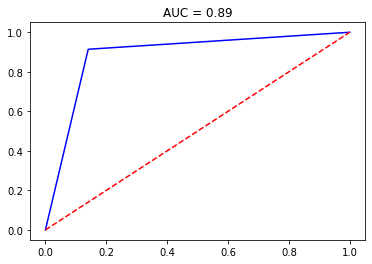

In [62]:
saca_metricas(y_test, y_pred_lr)

Con el modelo de **regresión logística** logramos un **86% de acierto**. La única pega del modelo es la baja precisión, es decir, **de los casos que detecta como abandono únicamente el 34% son correctos**. Sin embargo, **de los casos que realmente se van de la compañía es capaz de detectar correctamente el 91%**.  
Seguimos buscando modelos, en caso de no encontrar nada mejor, este modelo podría ser interesante al tener un **AUC de 0.88**.

### Random Forest

In [63]:
rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators = 100).fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

matriz de confusión
[[17590    86]
 [  585   832]]
accuracy
0.9648562300319489
precision
0.906318082788671
recall
0.5871559633027523
f1
0.7126338329764454
AUC
0.7911453045751146


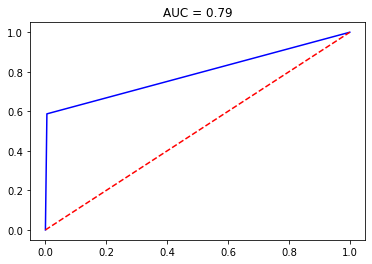

In [64]:
saca_metricas(y_test, y_pred_rf)

Con **Random Forest** se mejoran el acierto y la precisión considerablemente pero **la sensibilidad se ve muy afectada**. Esto afecta al **AUC, que siendo inferior al 0.8 es inaceptable**. El modelo acierta muy bien los ceros pero **falla mucho en la detección de abandonos de la compañía (entorno a un 42%). Lo descartamos ya que nuestro objetivo es evitar que el máximo número de clientes abandonen la compañía.**

### SVM clasificación

In [65]:
svm_classifier = LinearSVC(class_weight = 'balanced').fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

C:\Users\User\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


matriz de confusión
[[13381  4295]
 [   24  1393]]
accuracy
0.7737914418896978
precision
0.24490154711673698
recall
0.9830628087508821
f1
0.39211822660098516
AUC
0.8700389852760974


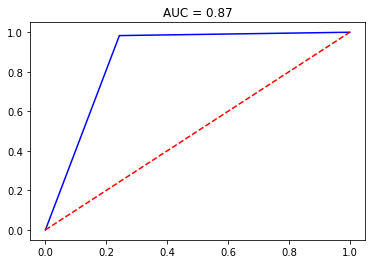

In [66]:
saca_metricas(y_test, y_pred_svm)

La tecnica **SVM para clasificación** tiene un AUC aceptable pero **la sensibilidad y la precisión son muy bajos**. El modelo falla mucho en la detecciónde clientes que abandonan la compañía. Seguimos teniendo como prioritario el modelo de Regresión Lineal.

### Naive Bayes

In [67]:
nb_classifier = GaussianNB().fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

matriz de confusión
[[13019  4657]
 [    5  1412]]
accuracy
0.755826742785314
precision
0.23265776898994892
recall
0.9964714184897672
f1
0.3772375100187016
AUC
0.8665034168710434


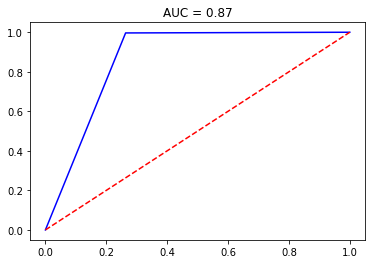

In [68]:
saca_metricas(y_test, y_pred_nb)

El modelo **Gaussian Naevy Bayes** tiene un AUC bueno y **la mejor sensibilidad de todas (0.99)**. En contra partida **la  precisión es la peor de todas**, de todos los casos que detecta como abandono, únicamente el 23% son verdaderos abandonos. Traducido a negocio **nos interesa sacrificar sensibilidad por el aumento de precisión de la regresión lineal** ya que si se quieren realizar acciones de rentención de clientes con alta probabilidad de abandono en este caso se destinarían muchos recursos a clientes que en verdad no quieren abandonar la compañía.

### Modelo ganador
> Seleccionamos el algoritmo de **regresión logísitca** como algoritmo ganador. Con la mejora de modelos buscaremos mejorar la precisión para subir el porcentaje de acierto de clientes que abandona y así optimizar la inversión en retención.

# 5. Mejora del modelo utilizando técnicas vistas en clase (feature engineering, análisis de variables, comprobación de overfitting, validación cruzada, tuneado de hiper parámetros a través de la automatización…) (20%)

### Validación cruzada

Para ver si el modelo elegido es preciso y no tiene sobre ajuste hacemos validación cruzada

#### Regresión lineal

In [69]:
lr_results = cross_val_score(estimator = lr_classifier, X = X_train, y=y_train, cv = 5)

In [70]:
lr_results

array([0.86179128, 0.86021998, 0.86362446, 0.86243698, 0.85988345])

In [71]:
# Confirmamos que no hay overfeating en el modelo de regresión lineal
print(f'Media --> {lr_results.mean()}')
print(f'Desviación tipica --> {lr_results.std()}')


Media --> 0.8615912311173858
Desviación tipica --> 0.0013918445490189758


# 6. Predecir los clientes de la cosecha de enero que más probabilidad tienen de cambiarse de operadora (10%)

In [72]:
# Clasifica 19.272 registros como posibles fugas
a = lr_classifier.predict(df_enero)
fuga = pd.DataFrame(a, index=df_enero.index)
fuga[fuga.loc[:,0]==1]

,0
id,
8,1
9,1
34,1
38,1
55,1
...,...
99963,1
99979,1
99984,1


In [73]:
modelo_proba = lr_classifier.predict_proba(df_enero)[:,1]
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=df_enero.index))
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [74]:
# Generamos lista en función de probabilidad de fuga para comenzar acciones de retención sobre clientes con mayor probabilidad.
modelo_proba[modelo_proba['probabilidad']>0.9]

,probabilidad
id,
24282,0.999999
7627,0.999999
67018,0.999999
6952,0.999998
53077,0.999991
...,...
34677,0.900191
31139,0.900132
78103,0.900092


# 7. Obtener y explicar las claves (a través de las variables…) de la marcha de los clientes en la compañía. (5%)

<AxesSubplot:>

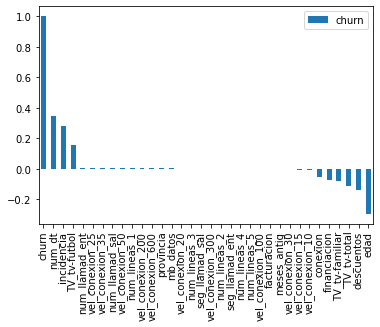

In [75]:
# Analizamos el tipo de correlación
corr = df_diciembre.corr()
corr[['churn']].sort_values(by='churn',ascending = False).plot(kind='bar')

Como podemos ver en el gráfico las cinco variables con mayor influencia sobre la tasa de abandono son:
1. Los clientes más jóvenes tienen mayor probabilidad de fuga
2. Los clientes que no disfrutan de descuentos tienen mayor probabilidad de fuga
3. Los clientes que comienzan con impago de lineas terminan por fugarse
4. Aquellos clientes con incidencias en el servicio tienen mayor probabilidad de fuga
5. Los clientes que únicamente tienen contratado el paquete de futbol son más propensos a irse que los que tienen televisión familiar o el pack completo de televisión.